1. Importación de Bibliotecas


In [11]:
# Importación de Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikeras
import tensorflow as tf
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from joblib import parallel_backend
from scikeras.wrappers import KerasClassifier

# Configuración de estilo de los gráficos
plt.style.use('ggplot')


In [12]:
print("scikit-learn version:", sklearn.__version__)
print("SciKeras version:", scikeras.__version__)
print("TensorFlow version:", tf.__version__)


scikit-learn version: 1.3.2
SciKeras version: 0.13.0
TensorFlow version: 2.17.0


2. Cargar y Visualizar el Dataset


In [16]:
# Se carga el dataset
data_url = "content/framingham_clean.csv"
data = pd.read_csv(data_url)

# Se muestra las primeras filas del dataset
data.head()

# Resumen general del dataset
data.info()

# Resumen estadístico
summary_stats = data.describe()
print(summary_stats)

# Verificación de valores faltantes
missing_values = data.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4240 non-null   int64  
 1   gender             4240 non-null   int64  
 2   age                4240 non-null   int64  
 3   education          4240 non-null   int64  
 4   currentSmoker      4240 non-null   int64  
 5   cigsPerDay         4240 non-null   int64  
 6   BPMeds             4240 non-null   object 
 7   prevalentStroke    4240 non-null   int64  
 8   prevalentHyp       4240 non-null   int64  
 9   diabetes           4240 non-null   int64  
 10  totChol            4240 non-null   int64  
 11  sysBP              4240 non-null   float64
 12  diaBP              4240 non-null   float64
 13  BMI                4240 non-null   float64
 14  heartRate          4240 non-null   int64  
 15  glucose            4240 non-null   int64  
 16  TenYearCHD         4240 

3. Preprocesamiento de los Datos


In [17]:
# Limpieza de datos
# Se reemplazan 'Missing' por 2 en BPMeds
data['BPMeds'] = data['BPMeds'].replace('Missing', 2)
# Se convierte BPMeds a numérico
data['BPMeds'] = pd.to_numeric(data['BPMeds'])

# Se convierte gender a texto
data['gender'] = data['gender'].astype(str).replace(['0', '1'], ['M', 'F'])

# Convertir currentSmoker a texto
data['currentSmoker'] = data['currentSmoker'].astype(str).replace(['0', '1'], ['NO', 'YES'])

# Se verifica tipos de datos después de la limpieza
print(data.dtypes)


Unnamed: 0             int64
gender                object
age                    int64
education              int64
currentSmoker         object
cigsPerDay             int64
BPMeds                 int64
prevalentStroke        int64
prevalentHyp           int64
diabetes               int64
totChol                int64
sysBP                float64
diaBP                float64
BMI                  float64
heartRate              int64
glucose                int64
TenYearCHD             int64
age_groups             int64
heart_rate_groups      int64
dtype: object


4. Exploración de Datos (EDA)


gender :
gender
M    2420
F    1820
Name: count, dtype: int64
------------------
education :
education
1    1825
2    1253
3     689
4     473
Name: count, dtype: int64
------------------
currentSmoker :
currentSmoker
NO     2145
YES    2095
Name: count, dtype: int64
------------------
BPMeds :
BPMeds
0    4063
1     124
2      53
Name: count, dtype: int64
------------------
prevalentStroke :
prevalentStroke
0    4215
1      25
Name: count, dtype: int64
------------------
prevalentHyp :
prevalentHyp
0    2923
1    1317
Name: count, dtype: int64
------------------
diabetes :
diabetes
0    4131
1     109
Name: count, dtype: int64
------------------


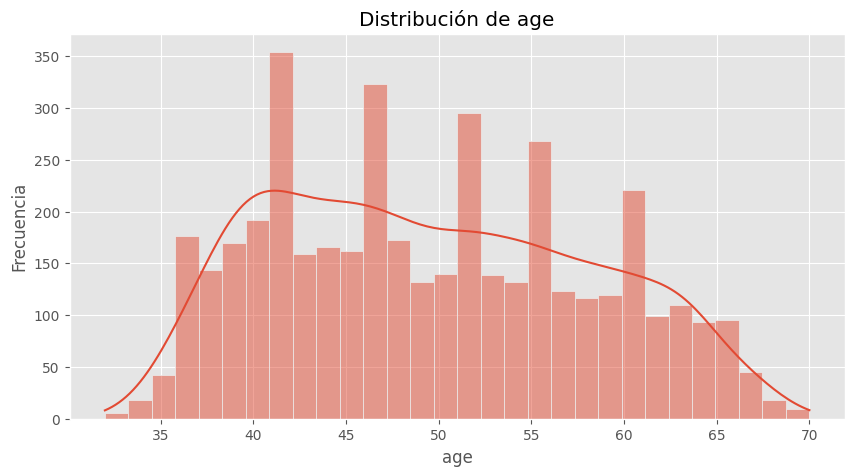

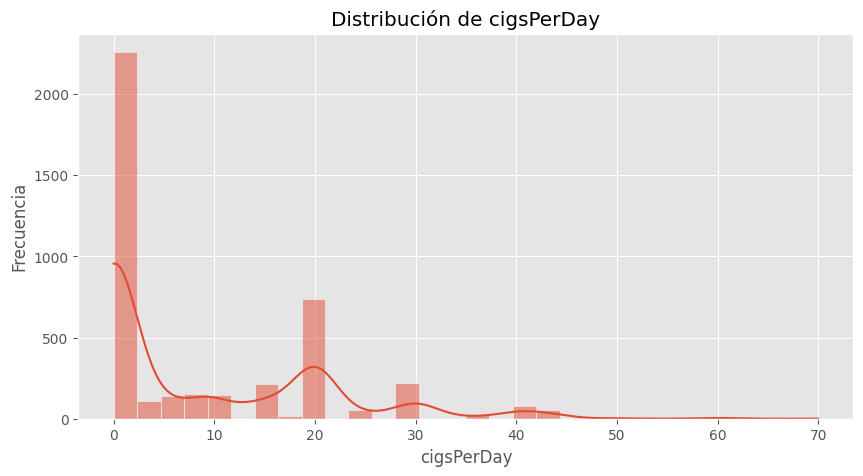

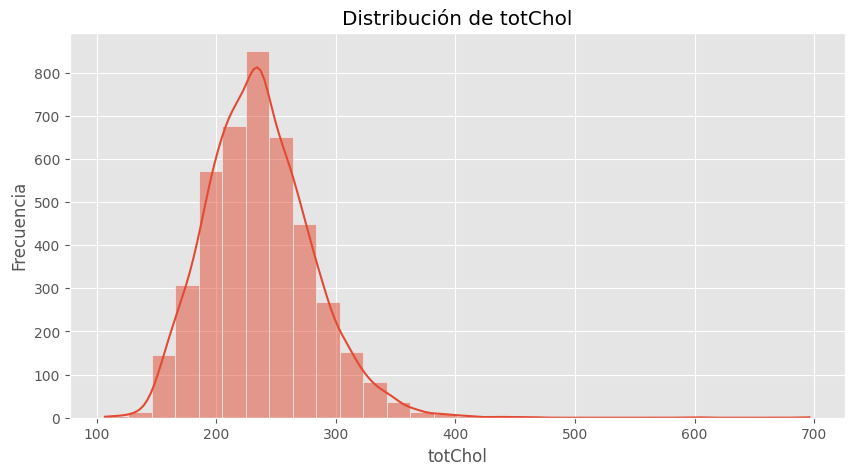

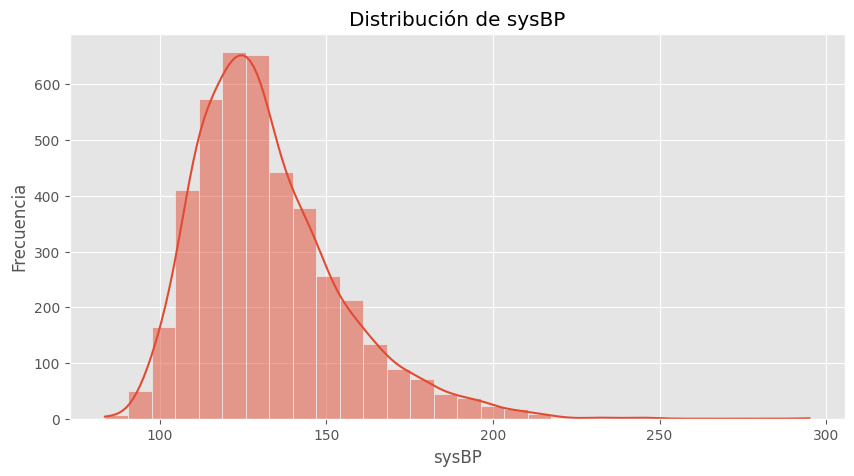

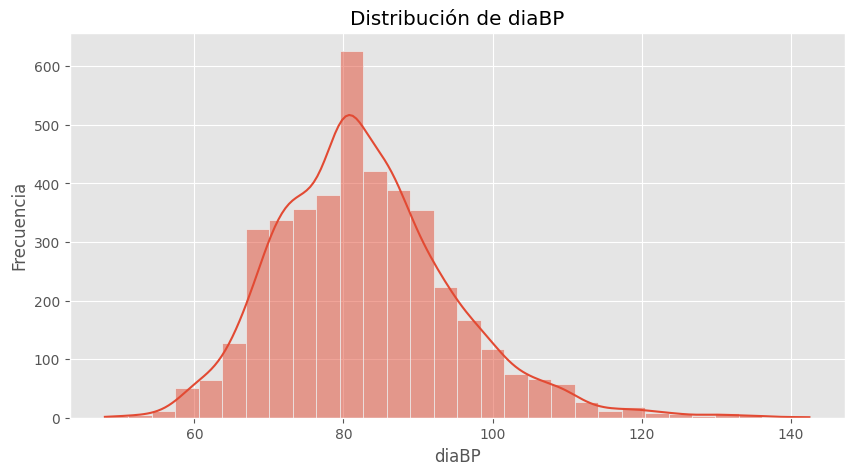

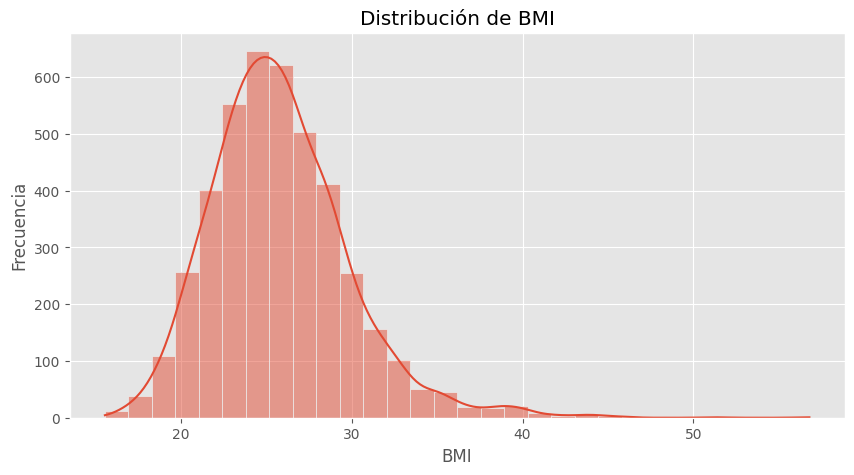

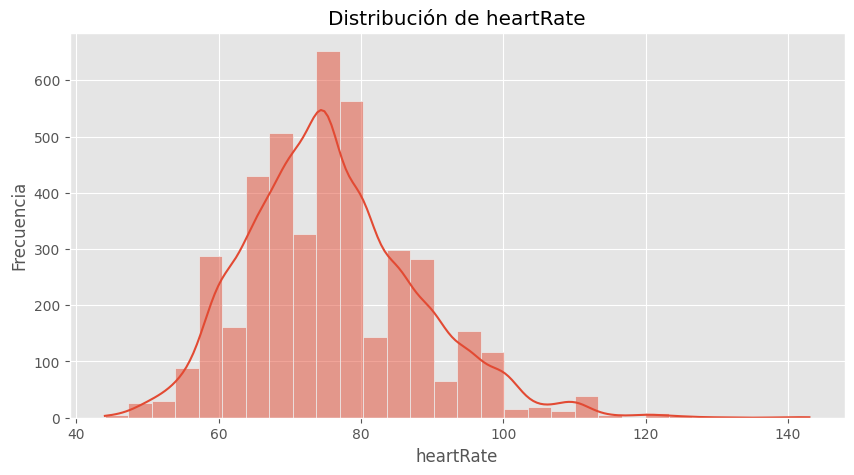

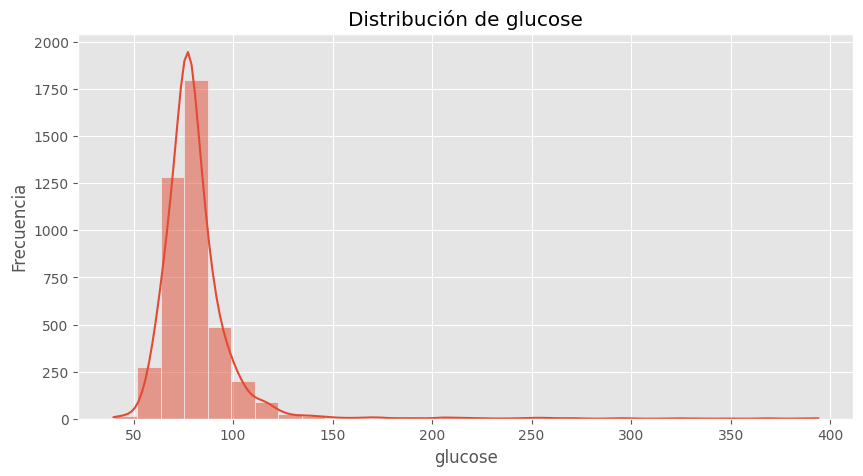

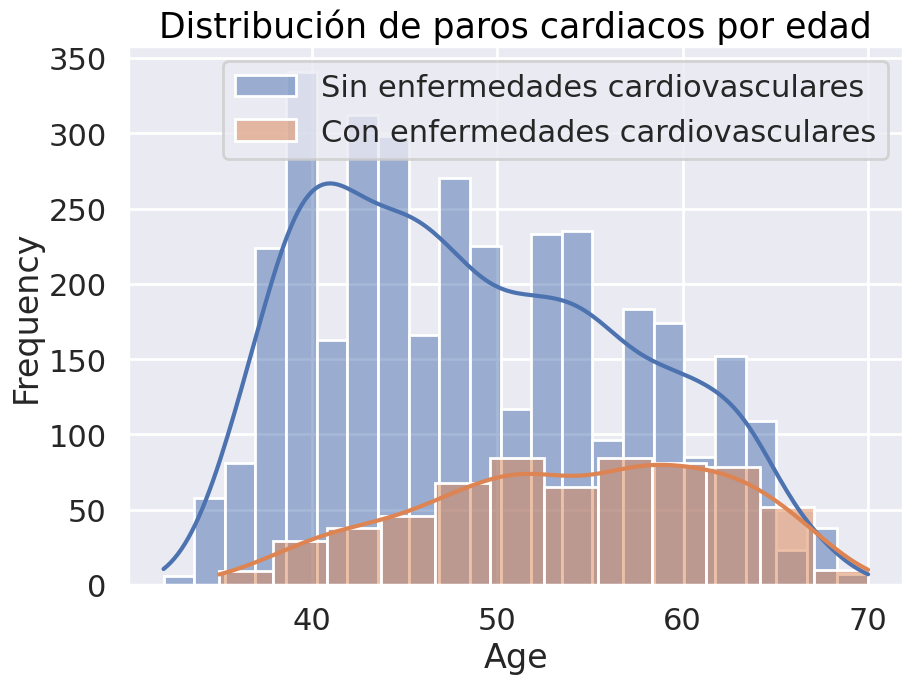

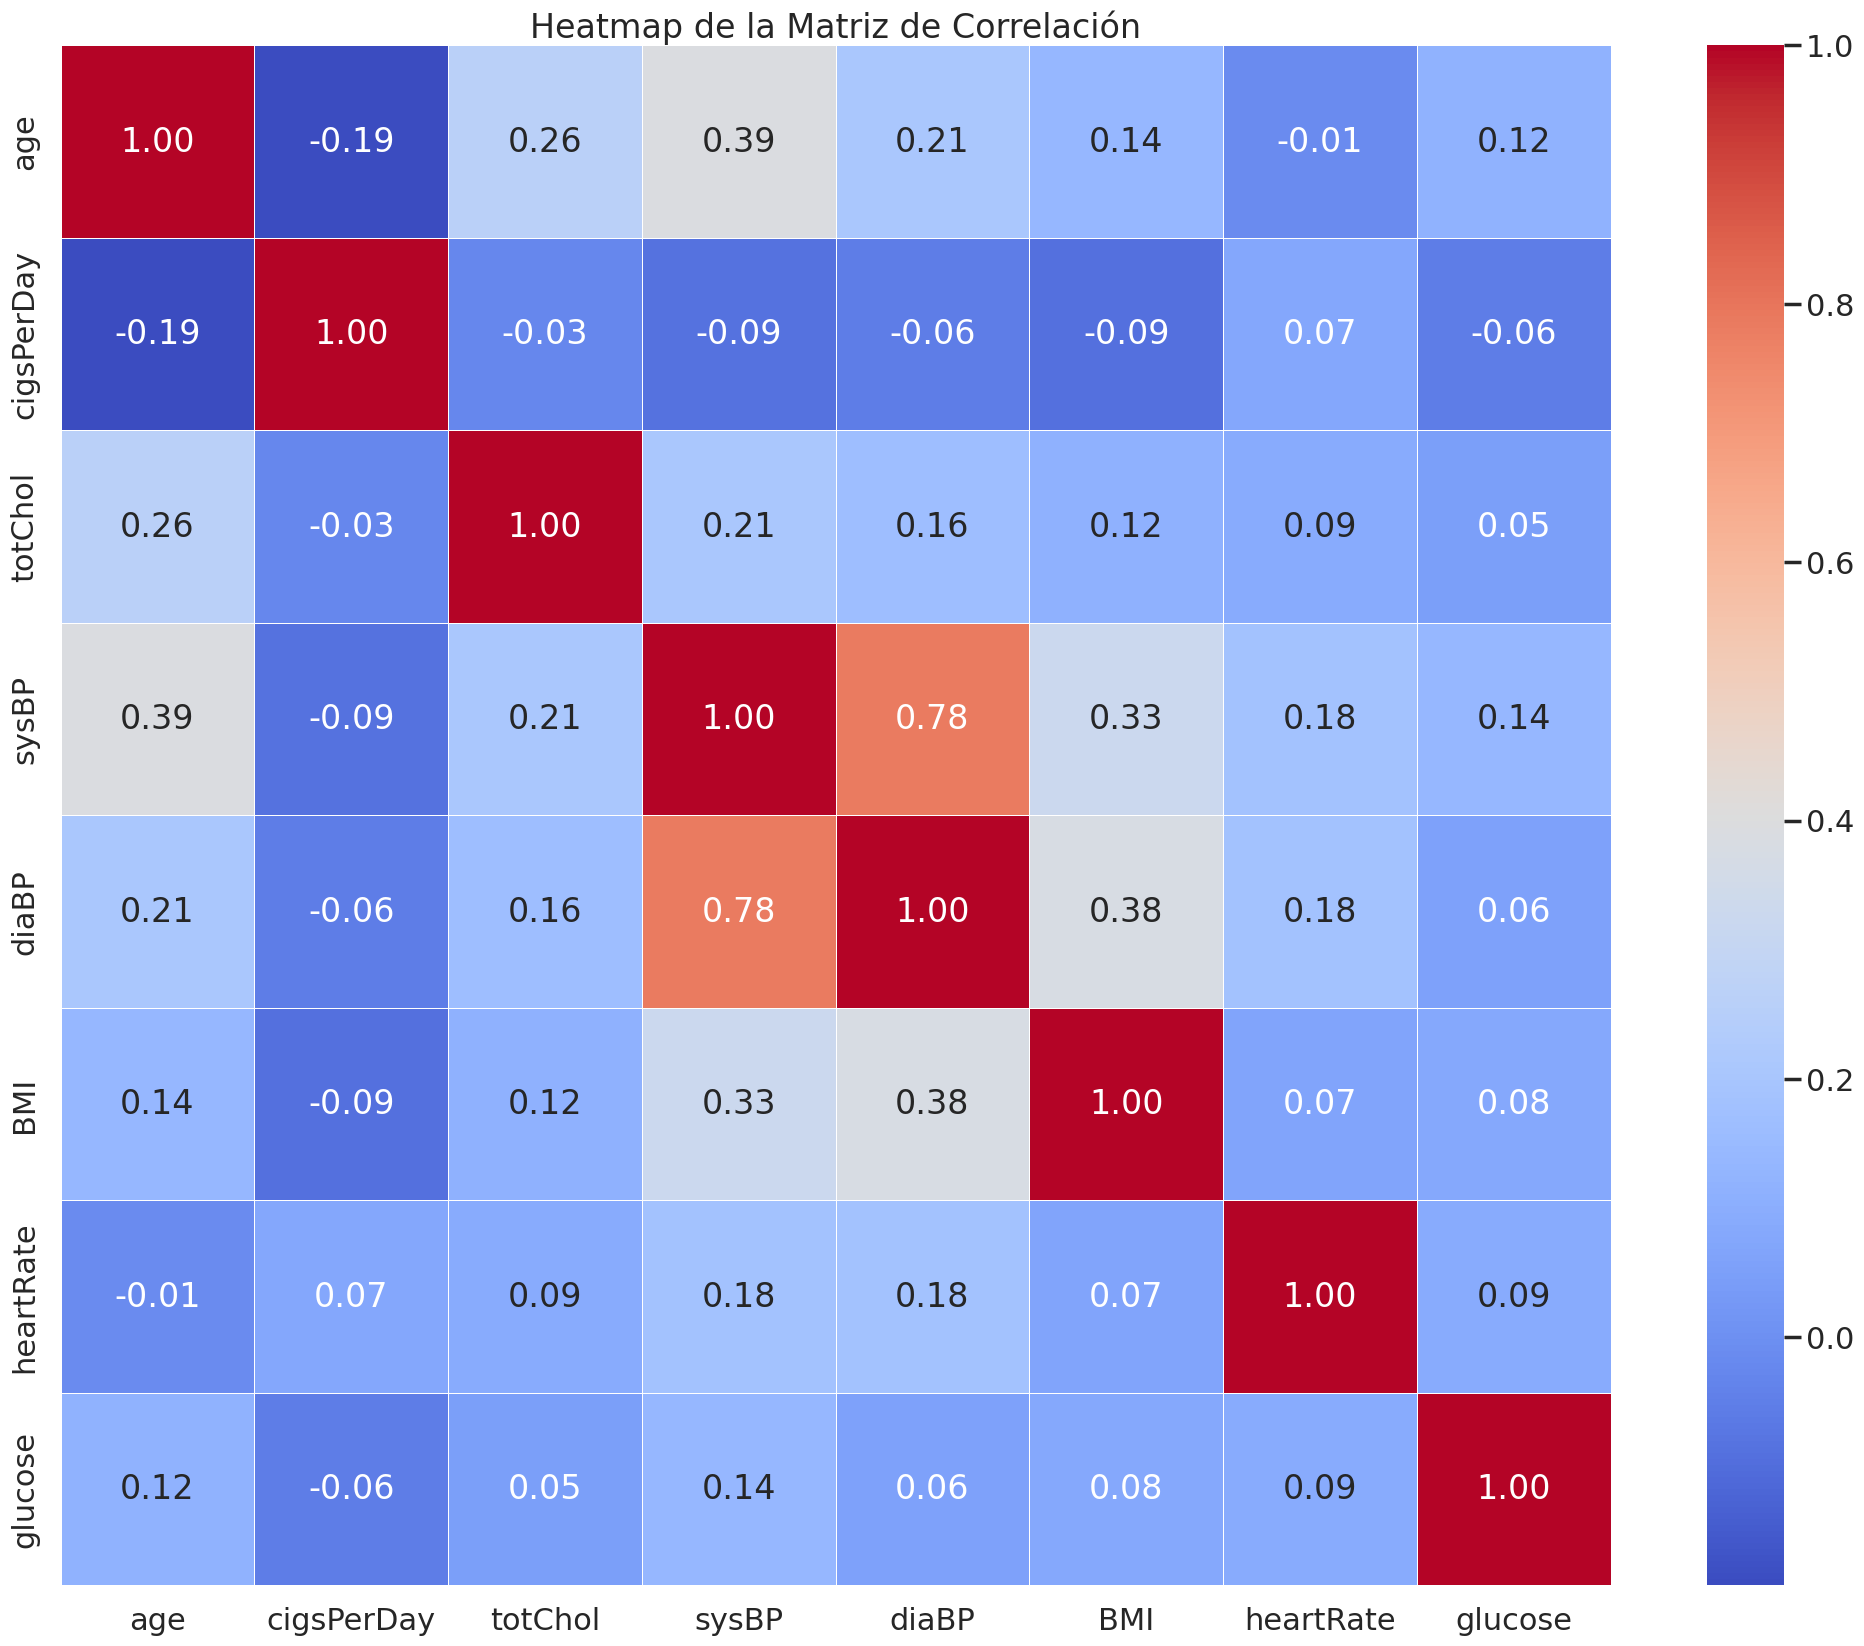

In [18]:
# Análisis univariado
categorical_vars = ['gender','education','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes']
for var in categorical_vars:
  print(var, ":")
  print(data[var].value_counts())
  print("------------------")

# Se crean histogramas y gráficos de densidad para variables numéricas
numeric_vars = ["age","cigsPerDay","totChol","sysBP","diaBP","BMI","heartRate","glucose"]

for var in numeric_vars:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[var], kde=True, bins=30)
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
    plt.show()

# Distribución de paros cardiacos según la edad
sns.set_theme(context='poster')
plt.figure(figsize=(10,7))
plt.title('Distribución de paros cardiacos por edad', color="Black", fontsize=25)

sns.histplot(data[data['TenYearCHD'] == 0]['age'], label='Sin enfermedades cardiovasculares', kde=True)
sns.histplot(data[data['TenYearCHD'] == 1]['age'], label='Con enfermedades cardiovasculares', kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Matriz de correlación y heatmap
correlation_matrix = data[numeric_vars].corr()

plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap de la Matriz de Correlación')
plt.show()


5. Análisis de Relaciones Categóricas


In [20]:
# Análisis de relaciones categóricas con TenYearCHD usando tablas de contingencia y chi-cuadrado
def chi_square_test(var):
    contingency_table = pd.crosstab(data[var], data['TenYearCHD'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return contingency_table, chi2, p

# Variables categóricas a analizar
categorical_vars_for_chi2 = ['gender', 'currentSmoker', 'education', 'prevalentStroke', 'prevalentHyp', 'diabetes']

for var in categorical_vars_for_chi2:
    contingency_table, chi2, p = chi_square_test(var)
    print(f'Tabla de contingencia para {var}:\n', contingency_table)
    print(f'Estadístico chi-cuadrado: {chi2}')
    print(f'Valor p: {p}\n')


Tabla de contingencia para gender:
 TenYearCHD     0    1
gender               
F           1477  343
M           2119  301
Estadístico chi-cuadrado: 32.61833491071199
Valor p: 1.1215175755662674e-08

Tabla de contingencia para currentSmoker:
 TenYearCHD        0    1
currentSmoker           
NO             1834  311
YES            1762  333
Estadístico chi-cuadrado: 1.4972035438574873
Valor p: 0.2211021442164888

Tabla de contingencia para education:
 TenYearCHD     0    1
education            
1           1486  339
2           1106  147
3            601   88
4            403   70
Estadístico chi-cuadrado: 31.051850034062287
Valor p: 8.289453270159487e-07

Tabla de contingencia para prevalentStroke:
 TenYearCHD          0    1
prevalentStroke           
0                3582  633
1                  14   11
Estadístico chi-cuadrado: 14.033657261599943
Valor p: 0.0001795675785918809

Tabla de contingencia para prevalentHyp:
 TenYearCHD       0    1
prevalentHyp           
0             

6. Análisis de Clustering


In [21]:
# Se verifican los tipos de datos en cada columna
print(data.dtypes)

# Se verifican los valores únicos en las columnas que no son numéricas
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Columna {col}: {data[col].unique()}")


Unnamed: 0             int64
gender                object
age                    int64
education              int64
currentSmoker         object
cigsPerDay             int64
BPMeds                 int64
prevalentStroke        int64
prevalentHyp           int64
diabetes               int64
totChol                int64
sysBP                float64
diaBP                float64
BMI                  float64
heartRate              int64
glucose                int64
TenYearCHD             int64
age_groups             int64
heart_rate_groups      int64
dtype: object
Columna gender: ['F' 'M']
Columna currentSmoker: ['NO' 'YES']


In [31]:
# Se identifican y convierten las columnas no numéricas
data['BPMeds'] = data['BPMeds'].replace({'Missing': 2}).astype(float)
data['gender'] = data['gender'].replace({'M': 0, 'F': 1}).astype(int)
data['currentSmoker'] = data['currentSmoker'].replace({'NO': 0, 'YES': 1}).astype(int)

# Estandarización de los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop(columns=['TenYearCHD', 'Unnamed: 0']))

# Se aplica PCA para reducción de dimensionalidad
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  self._algorithm = self.algorithm
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  self._algorithm = self.algorithm
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  self._algorithm = self.algorithm
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  self._algorithm = self.al

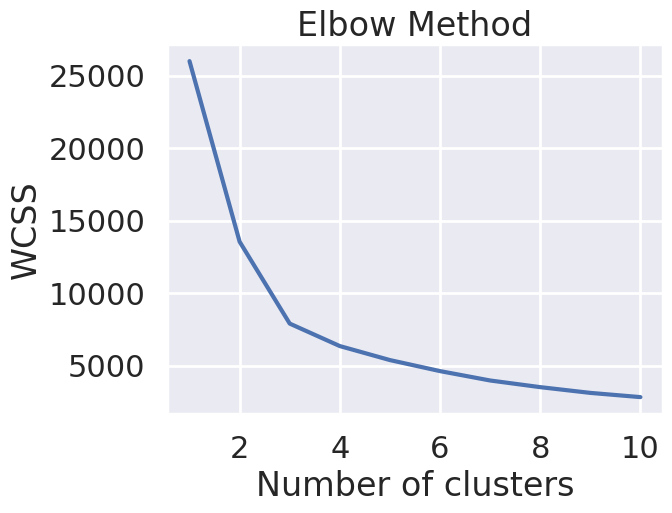

In [32]:
# Se calcula el número de clusters óptimo mediante el método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  self._algorithm = self.algorithm


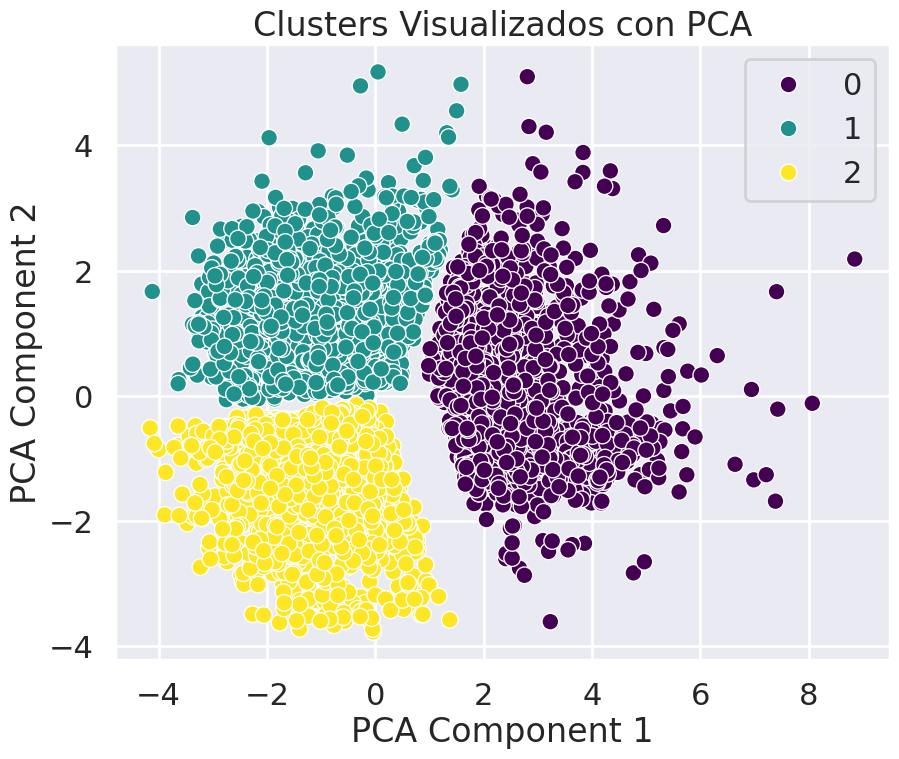

In [35]:
# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_pca)

# Se agregan los clusters al DataFrame original
data['Cluster'] = clusters

# Visualización de los clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=clusters, palette='viridis')
plt.title('Clusters Visualizados con PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [40]:
# Agrupar los datos por cluster y calcular la proporción de pacientes con enfermedad
proporciones = data.groupby('Cluster')['TenYearCHD'].mean()
print(proporciones)

edades = data.groupby('Cluster')['age'].mean()
print(edades)

bmis = data.groupby('Cluster')['BMI'].mean()
print(bmi)

diabetes = data.groupby('Cluster')['diabetes'].mean()
print(diabetes)

heartrates = data.groupby('Cluster')['heartRate'].mean()
print(heartrates)

Cluster
0    0.268170
1    0.114268
2    0.097327
Name: TenYearCHD, dtype: float64
Cluster
0    55.677527
1    44.072601
2    50.557231
Name: age, dtype: float64
Cluster
0    27.950468
1    24.717645
2    25.207896
Name: BMI, dtype: float64
Cluster
0    0.071011
1    0.006944
2    0.008910
Name: diabetes, dtype: float64
Cluster
0    79.974102
1    78.078283
2    70.130912
Name: heartRate, dtype: float64


7. Preparación y Preprocesamiento de Datos para Modelado


In [41]:
# Separación de características y variable objetivo
X = data.drop(columns=['TenYearCHD', 'Unnamed: 0'])
y = data['TenYearCHD']

# Se convierten las variables categóricas a numéricas
X['gender'] = X['gender'].replace({'M': 0, 'F': 1}).astype(int)
X['currentSmoker'] = X['currentSmoker'].replace({'NO': 0, 'YES': 1}).astype(int)

# Comprobación de que todas las columnas sean numéricas
X = X.apply(pd.to_numeric, errors='coerce')

# Verificación de si hay columnas con valores NaN después de la conversión
print(X.isnull().sum())

# Preprocesamiento de datos
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

gender               0
age                  0
education            0
currentSmoker        0
cigsPerDay           0
BPMeds               0
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              0
sysBP                0
diaBP                0
BMI                  0
heartRate            0
glucose              0
age_groups           0
heart_rate_groups    0
Cluster              0
dtype: int64


8. Balanceo de Clases con SMOTE


In [42]:
# Balanceo de clases usando SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

9. División del Conjunto de Datos


In [43]:
# División del dataset balanceado en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

10. Implementación de la Red Neuronal con Ajuste de Hiperparámetros


In [44]:
# Se define una función para construir el modelo de la red neuronal
def build_model(optimizer='adam', kernel_initializer='glorot_uniform'):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, kernel_initializer=kernel_initializer, activation='relu'))
    model.add(Dense(1, kernel_initializer=kernel_initializer, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Se crea el modelo KerasClassifier
model = KerasClassifier(
    model=build_model,
    verbose=0
)

# Creación del grid de hiperparámetros
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 200],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__kernel_initializer': ['glorot_uniform', 'normal', 'uniform']
}

# Implementación de la búsqueda aleatoria de hiperparámetros
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, scoring='accuracy', cv=3, verbose=1, n_jobs=1, error_score='raise')

# Se envuelve el fit con parallel_backend por si es necesario para evitar problemas en ciertos entornos
with parallel_backend('threading'):
    grid_result = grid.fit(X_train, y_train)

# Se imprimen los mejores hiperparámetros
print("Mejores Hiperparámetros: %s utilizando %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Mejores Hiperparámetros: 0.7389171471108348 utilizando {'model__optimizer': 'rmsprop', 'model__kernel_initializer': 'normal', 'epochs': 200, 'batch_size': 64}


11.Evaluar el mejor modelo

In [45]:
# Se obtiene el mejor modelo de la búsqueda de hiperparámetros
best_model = grid.best_estimator_

# Evaluación del modelo en el conjunto de prueba
test_accuracy = best_model.score(X_test, y_test)

print(f"Test Accuracy: {test_accuracy}")


Test Accuracy: 0.7234190410006949


In [46]:
# Se calcula la pérdida (loss) en el conjunto de prueba
test_loss = best_model.model_.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")


Test Accuracy: 0.7234190410006949
Test Loss: [0.5512812733650208, 0.7234190702438354]


12. Revisar los Resultados de la Búsqueda de Hiperparámetros

In [47]:
# Resultados de la búsqueda de hiperparámetros
print("Mejores Hiperparámetros: %s utilizando %s" % (grid_result.best_score_, grid_result.best_params_))

# Se muestran los resultados detallados de cada combinación de hiperparámetros probada
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))


Mejores Hiperparámetros: 0.7389171471108348 utilizando {'model__optimizer': 'rmsprop', 'model__kernel_initializer': 'normal', 'epochs': 200, 'batch_size': 64}
0.738917 (0.006855) with: {'model__optimizer': 'rmsprop', 'model__kernel_initializer': 'normal', 'epochs': 200, 'batch_size': 64}
0.710759 (0.002405) with: {'model__optimizer': 'rmsprop', 'model__kernel_initializer': 'normal', 'epochs': 100, 'batch_size': 64}
0.715974 (0.004451) with: {'model__optimizer': 'rmsprop', 'model__kernel_initializer': 'uniform', 'epochs': 100, 'batch_size': 64}
0.721360 (0.013687) with: {'model__optimizer': 'rmsprop', 'model__kernel_initializer': 'uniform', 'epochs': 200, 'batch_size': 64}
0.730399 (0.012075) with: {'model__optimizer': 'rmsprop', 'model__kernel_initializer': 'uniform', 'epochs': 200, 'batch_size': 16}


13.Evaluar el Modelo en el Conjunto de Prueba

In [48]:
# Entrenamiento el modelo con los mejores hiperparámetros
best_model = grid_result.best_estimator_

# Evaluación el modelo en el conjunto de prueba
test_accuracy = best_model.score(X_test, y_test)
print("Accuracy en el conjunto de prueba: %.2f%%" % (test_accuracy * 100))

# Predicción en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Se genera un informe de clasificación
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy en el conjunto de prueba: 72.34%
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74       745
           1       0.73      0.67      0.70       694

    accuracy                           0.72      1439
   macro avg       0.72      0.72      0.72      1439
weighted avg       0.72      0.72      0.72      1439

Confusion Matrix:
 [[573 172]
 [226 468]]


14. Guardar el modelo

In [49]:
model.save('modelo_keras.h5')


AttributeError: 'KerasClassifier' object has no attribute 'save'